# Analysis of annotations_df_230311

This notebook contains analysis of:
1. Overall summary of task performances
2. Analyses of relationships between tasks
3. Visualisation of influences on task performance (difficulty effects)

See notes.md for additional background information on annoations.

In [1]:
import os
import pandas as pd
import numpy as np
import itertools
import random
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
sns.set_style("white")
random.seed(351492)

## Import data

In [3]:
# Create groups of algorithms which are compared within plots
all_algos = ['SD1.2','SD1.5','SD2.1','Dalle','MJ']
across_algos = ['Dalle','MJ','SD2.1']
within_SD = ['SD1.2','SD1.5','SD2.1']

In [4]:
# Import prompt directory
prompt_dir = pd.read_csv('Prompt_dir_230228_extraVars.csv',index_col=0).drop(columns=['Unnamed: 0'])
prompt_dir.head()

,ID,Prompt,Representations,Auto_assessment,Task,Task_specific_label,img2img_instructions,Object_num,Extra_characteristic,Num_features,Common,Num_objects,Linked_prompts
0,1,A sweet strawberry or a sour lemon- only rende...,strawberry,True,Conditional generation,lemon,NaN,1.0,False,NaN,NaN,NaN,1801
1,2,A soft blanket or a hard bench- only render so...,blanket,False,Conditional generation,bench,NaN,1.0,False,NaN,NaN,NaN,1802
2,3,A soft towel or a cabinet- only render furniture,cabinet,True,Conditional generation,towel,NaN,2.0,False,NaN,NaN,NaN,1803
3,4,A white carpet or a hard floor- only render ha...,carpet,False,Conditional generation,floor,NaN,1.0,True,NaN,NaN,NaN,1804
4,5,A white mug or a black pen- only render white ...,mug,False,Conditional generation,pen,NaN,1.0,True,NaN,NaN,NaN,1805


In [5]:
# Import annotation data
annotations_df = pd.read_csv('annotations_df_230311.csv')

## Overall task performance

### Mean across all tasks

We exclude the "Controlled" tasks here as they contain repeated prompts which would bias the average performance numbers.

In [6]:
mean_df = annotations_df.loc[~(annotations_df['Task'].str.startswith('Controlled'))].copy()
mean_df.groupby(['Algorithm'])['annotation'].mean().reset_index()

,Algorithm,annotation
0,Dalle,0.547441
1,MJ,0.464419
2,SD1.5,0.350811
3,SD2.1,0.343321


### Mean performance by task and algorithm

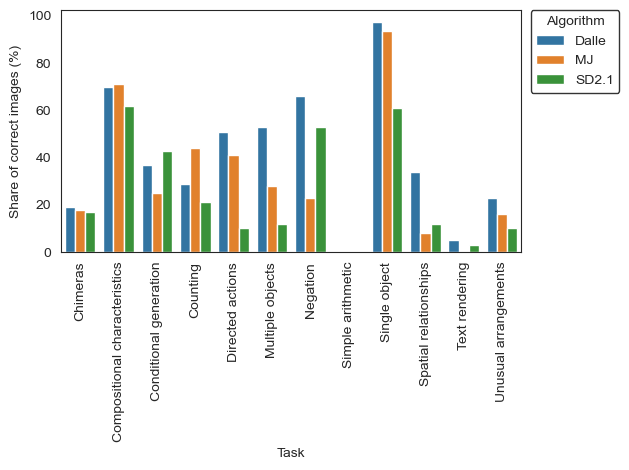

In [7]:
plot_df = annotations_df.loc[
    (annotations_df['Algorithm'].isin(across_algos))&
    ~(annotations_df['Task'].str.startswith('Controlled'))].copy()
plot_df = plot_df.groupby(['Algorithm','Task'])['annotation'].mean().reset_index()
plot_df['annotation']=plot_df['annotation']*100
sns.barplot(data=plot_df, x="Task", y="annotation",hue='Algorithm')
_ = plt.xticks(rotation=90)
_ = plt.ylabel('Share of correct images (%)')
_ = plt.legend(title='Algorithm',bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,edgecolor='black')
plt.tight_layout()

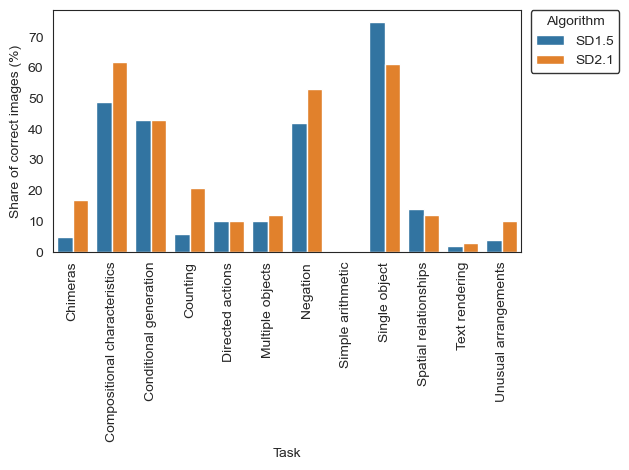

In [8]:
plot_df = annotations_df.loc[
    (annotations_df['Algorithm'].isin(within_SD))&
    ~(annotations_df['Task'].str.startswith('Controlled'))].copy()
plot_df = plot_df.groupby(['Algorithm','Task'])['annotation'].mean().reset_index()
plot_df['annotation']=plot_df['annotation']*100
sns.barplot(data=plot_df, x="Task", y="annotation",hue='Algorithm')
_ = plt.xticks(rotation=90)
_ = plt.ylabel('Share of correct images (%)')
_ = plt.legend(title='Algorithm',bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,edgecolor='black')
plt.tight_layout()

### Mean performance by task and algorithm (controlled tasks)

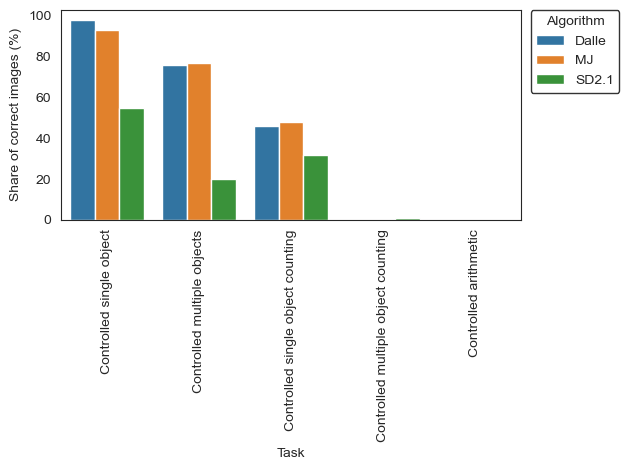

In [9]:
label_order = ['Controlled single object','Controlled multiple objects', 'Controlled single object counting', 'Controlled multiple object counting', 'Controlled arithmetic']
plot_df = annotations_df.loc[
    (annotations_df['Algorithm'].isin(across_algos))&
    (annotations_df['Task'].str.startswith('Controlled'))].copy()
plot_df = plot_df.groupby(['Algorithm','Task'])['annotation'].mean().reset_index()
plot_df['annotation']=plot_df['annotation']*100
sns.barplot(data=plot_df, x="Task", y="annotation",hue='Algorithm',order=label_order)
_ = plt.xticks(rotation=90)
_ = plt.ylabel('Share of correct images (%)')
_ = plt.legend(title='Algorithm',bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,edgecolor='black')
plt.tight_layout()

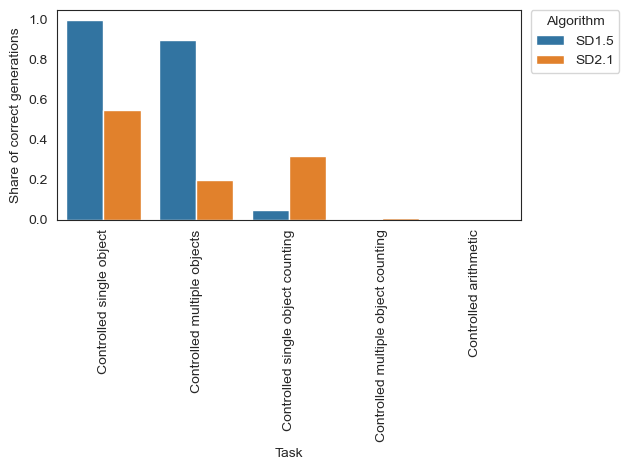

In [10]:
label_order = ['Controlled single object','Controlled multiple objects', 'Controlled single object counting', 'Controlled multiple object counting', 'Controlled arithmetic']
plot_df = annotations_df.loc[
    (annotations_df['Algorithm'].isin(within_SD))&
    (annotations_df['Task'].str.startswith('Controlled'))].copy()
plot_df = plot_df.groupby(['Algorithm','Task'])['annotation'].mean().reset_index()
sns.barplot(data=plot_df, x="Task", y="annotation",hue='Algorithm',order=label_order)
_ = plt.xticks(rotation=90)
_ = plt.ylabel('Share of correct generations')
_ = plt.legend(title='Algorithm',bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

## Mean performance by related single object performance

Here we plot a model's mean performance on tasks as a function on how good it is at generating the single objects which are  part of these prompts.

In [11]:
# Calculate every models mean performance on each task (except img2img, controlled and single objects)
temp_df = annotations_df.loc[
    ~(annotations_df['Task'].str.startswith('img2img'))&
    ~(annotations_df['Task'].str.startswith('Controlled'))&
    ~(annotations_df['Task'].str.startswith('Single object'))].copy()
temp_df = temp_df.groupby(['Algorithm','Task'])['annotation'].mean().reset_index()
temp_df['Single_object_performance']=np.nan

In [12]:
# Calculate the mean performance on linked single objects prompts 
temp_task_list = temp_df.Task.unique()

for i_task, i_algo in itertools.product(temp_task_list,all_algos):
    # From annotations_df, extract list of all prompts linked to the current set of prompts
    curr_linked_single_objects = annotations_df.loc[(annotations_df['Task']==i_task)&(annotations_df['Algorithm']==i_algo)].Linked_prompts
    curr_linked_single_objects = curr_linked_single_objects.str.split(',').explode().unique().astype('int')
    curr_linked_single_objects = annotations_df.loc[(annotations_df['ID'].isin(curr_linked_single_objects))&(annotations_df['Algorithm']==i_algo)]
    # Calculate the success rate in generating these single objects
    curr_linked_single_objects_performance = curr_linked_single_objects.annotation.mean()
    # Add this success rate to temp_df
    temp_df.loc[(temp_df['Task']==i_task)&(temp_df['Algorithm']==i_algo),'Single_object_performance'] = curr_linked_single_objects_performance

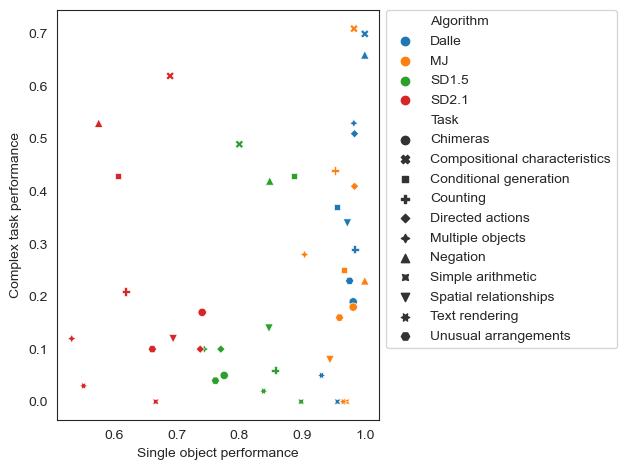

In [13]:
sns.scatterplot(data=temp_df, x="Single_object_performance", y="annotation",hue='Algorithm',style='Task')
_ = plt.ylabel('Complex task performance')
_ = plt.xlabel('Single object performance')
_ = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

### Statistical analysis of relationship

Note that we exclude "Text rendering" and "Simple arithmetic" for this analysis. These tasks would have a biased influence on the analysis as algorithms can categorically not solve these tasks yet. Even with this correction the relationship is not significant.

In [14]:
# Calculate every models mean performance on each task (except img2img, controlled and single objects)
temp_df = annotations_df.loc[
    ~(annotations_df['Task'].str.startswith('img2img'))&
    ~(annotations_df['Task'].str.startswith('Controlled'))&
    ~(annotations_df['Task'].str.startswith('Single object'))&
    ~(annotations_df['Task'].isin(['Text rendering',"Simple arithmetic"]))].copy()
temp_df = temp_df.groupby(['Algorithm','Task'])['annotation'].mean().reset_index()
temp_df['Single_object_performance']=np.nan


# Calculate the mean performance on linked single objects prompts 
temp_task_list = temp_df.Task.unique()

for i_task, i_algo in itertools.product(temp_task_list,all_algos):
    # From annotations_df, extract list of all prompts linked to the current set of prompts
    curr_linked_single_objects = annotations_df.loc[(annotations_df['Task']==i_task)&(annotations_df['Algorithm']==i_algo)].Linked_prompts
    curr_linked_single_objects = curr_linked_single_objects.str.split(',').explode().unique().astype('int')
    curr_linked_single_objects = annotations_df.loc[(annotations_df['ID'].isin(curr_linked_single_objects))&(annotations_df['Algorithm']==i_algo)]
    # Calculate the success rate in generating these single objects
    curr_linked_single_objects_performance = curr_linked_single_objects.annotation.mean()
    # Add this success rate to temp_df
    temp_df.loc[(temp_df['Task']==i_task)&(temp_df['Algorithm']==i_algo),'Single_object_performance'] = curr_linked_single_objects_performance

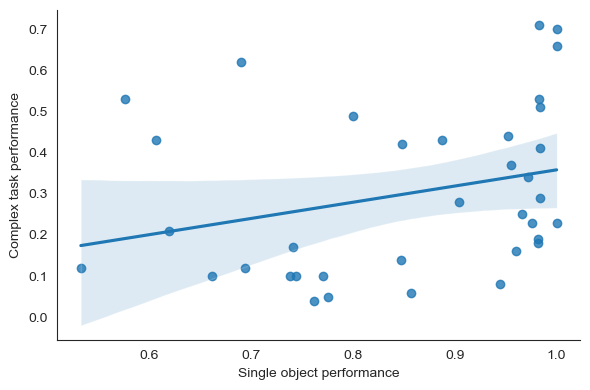

In [15]:
sns.lmplot(data=temp_df, x="Single_object_performance", y="annotation",height=4,aspect=1.5,n_boot=10000)
_ = plt.ylabel('Complex task performance')
_ = plt.xlabel('Single object performance')

In [16]:
mod = smf.ols(formula='annotation ~ Single_object_performance', data=temp_df)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             annotation   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     2.912
Date:                Wed, 22 Mar 2023   Prob (F-statistic):             0.0970
Time:                        15:13:54   Log-Likelihood:                 8.8071
No. Observations:                  36   AIC:                            -13.61
Df Residuals:                      34   BIC:                            -10.45
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.0357      0.199     -0.179      0.859      -0.441       0.369
Single_object_performance     0.3938      0.231      1.707      0.097      -0.075       0.863
==============================================================================
Omnibus:                        4.506   Durbin-Watson:                   1.781
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                3.393
Skew:                           0.616   Prob(JB):                        0.183
Kurtosis:                       2.137   Cond. No.                         12.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Visualisation of relationship split by algorithms

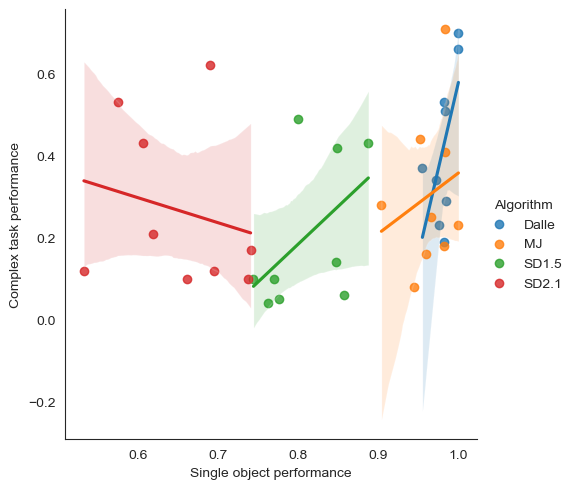

In [17]:
sns.lmplot(data=temp_df, x="Single_object_performance", y="annotation",hue='Algorithm')
_ = plt.ylabel('Complex task performance')
_ = plt.xlabel('Single object performance')

### Isolating effect on multiple object task performance

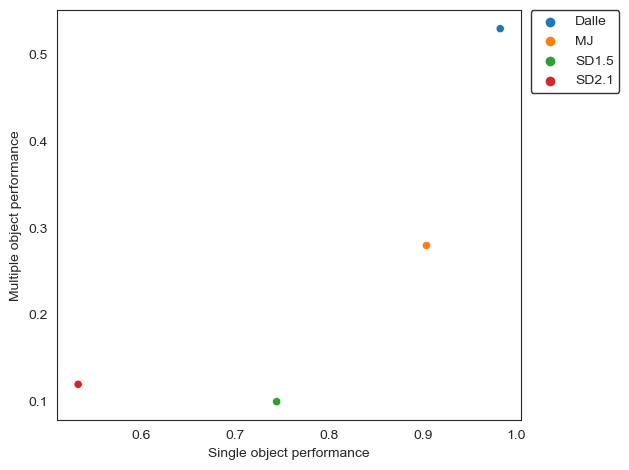

In [18]:
# Only show multiple object performance
temp_plot_df = temp_df.loc[temp_df['Task']=='Multiple objects']
sns.scatterplot(data=temp_plot_df, x="Single_object_performance", y="annotation",hue='Algorithm')
_ = plt.ylabel('Multiple object performance')
_ = plt.xlabel('Single object performance')
_ = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,edgecolor='black')
plt.tight_layout()

## Mean performance by multi object performance

Plot a models mean multi object performance by performance in upstream tasks. We do this for related ('Spatial relationships','Unusual arrangements','Directed actions') and unrelated ('Compositional characteristics','Conditional generation') tasks. 

### Related tasks

In [19]:
# Calculate every models mean performance on tasks upstream of multiple object generation
temp_task_list = ['Spatial relationships','Unusual arrangements','Directed actions']
temp_df = annotations_df.loc[(annotations_df['Task'].isin(temp_task_list))].copy()
temp_df = temp_df.groupby(['Algorithm','Task'])['annotation'].mean().reset_index()
temp_df['Multiple_object_performance']=np.nan

In [20]:
for i_algo in all_algos:
    # Get data on multi object prompts from current algorithms
    multi_object_prompts = annotations_df.loc[(annotations_df['Task']=='Multiple objects')&(annotations_df['Algorithm']==i_algo)]
    # Calculate the success rate in generating multiple objects
    multi_object_performance = multi_object_prompts.annotation.mean()
    # Add this success rate to temp_df
    temp_df.loc[(temp_df['Algorithm']==i_algo),'Multiple_object_performance'] = multi_object_performance

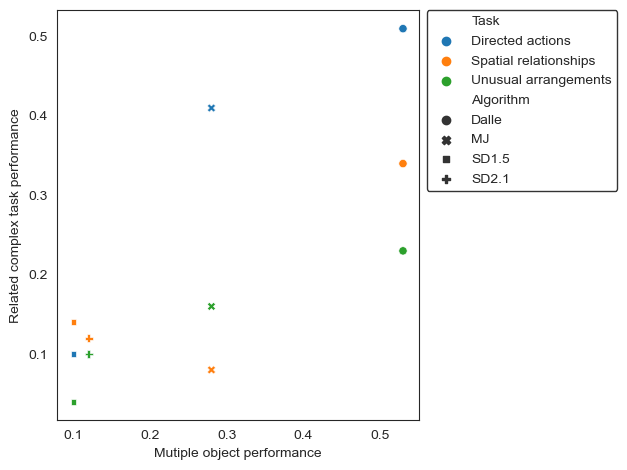

In [21]:
sns.scatterplot(data=temp_df, x='Multiple_object_performance', y="annotation",style='Algorithm',hue='Task')
_ = plt.ylabel('Related complex task performance')
_ = plt.xlabel('Mutiple object performance')
_ = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,edgecolor='black')
plt.tight_layout()

### Unrelated tasks

In [22]:
# Calculate every models mean performance on tasks which are not upstream of multiple object generation
temp_task_list = ['Compositional characteristics','Conditional generation']
temp_df = annotations_df.loc[(annotations_df['Task'].isin(temp_task_list))].copy()
temp_df = temp_df.groupby(['Algorithm','Task'])['annotation'].mean().reset_index()
temp_df['Multiple_object_performance']=np.nan

In [23]:
for i_algo in all_algos:
    # Get data on multi object prompts from current algorithms
    multi_object_prompts = annotations_df.loc[(annotations_df['Task']=='Multiple objects')&(annotations_df['Algorithm']==i_algo)]
    # Calculate the success rate in generating multiple objects
    multi_object_performance = multi_object_prompts.annotation.mean()
    # Add this success rate to temp_df
    temp_df.loc[(temp_df['Algorithm']==i_algo),'Multiple_object_performance'] = multi_object_performance

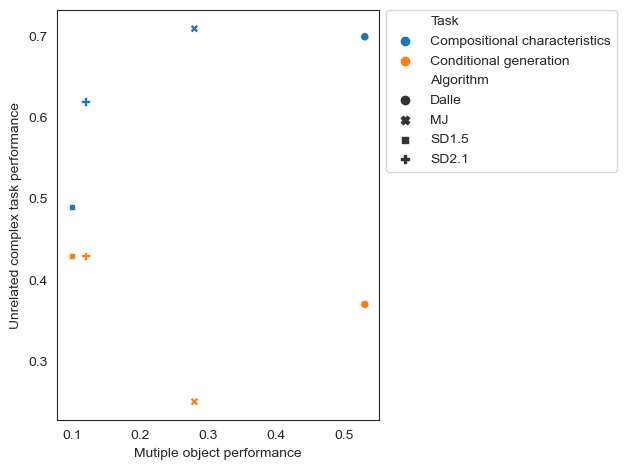

In [24]:
sns.scatterplot(data=temp_df, x='Multiple_object_performance', y="annotation",style='Algorithm',hue='Task')
_ = plt.ylabel('Unrelated complex task performance')
_ = plt.xlabel('Mutiple object performance')
_ = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

### Combined related / unrelated task relationship

#### Visualisations

In [25]:
# Calculate every models mean performance on tasks which are not upstream of multiple object generation
temp_task_list = ['Compositional characteristics','Conditional generation','Spatial relationships','Unusual arrangements','Directed actions']
temp_df = annotations_df.loc[(annotations_df['Task'].isin(temp_task_list))].copy()
temp_df = temp_df.groupby(['Algorithm','Task'])['annotation'].mean().reset_index()
temp_df['Multiple_object_performance']=np.nan

In [26]:
for i_algo in all_algos:
    # Get data on multi object prompts from current algorithms
    multi_object_prompts = annotations_df.loc[(annotations_df['Task']=='Multiple objects')&(annotations_df['Algorithm']==i_algo)]
    # Calculate the success rate in generating multiple objects
    multi_object_performance = multi_object_prompts.annotation.mean()
    # Add this success rate to temp_df
    temp_df.loc[(temp_df['Algorithm']==i_algo),'Multiple_object_performance'] = multi_object_performance

In [27]:
temp_df.loc[temp_df['Task'].isin(['Compositional characteristics','Conditional generation']),"Relatedness"]='Unrelated'
temp_df.loc[temp_df['Task'].isin(['Spatial relationships','Unusual arrangements','Directed actions']),"Relatedness"]='Related'

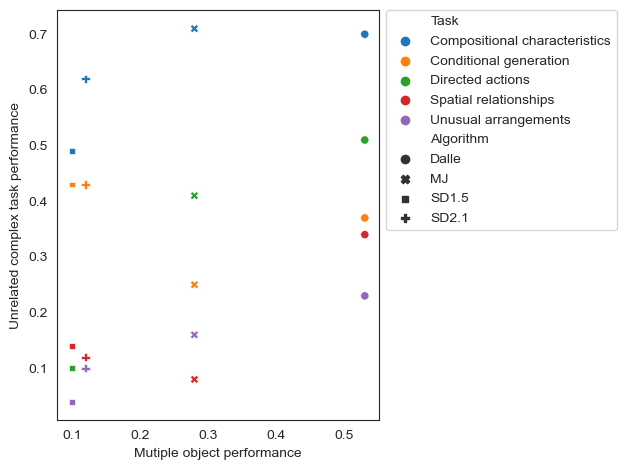

In [28]:
sns.scatterplot(data=temp_df, x='Multiple_object_performance', y="annotation",style='Algorithm',hue='Task')
_ = plt.ylabel('Unrelated complex task performance')
_ = plt.xlabel('Mutiple object performance')
_ = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

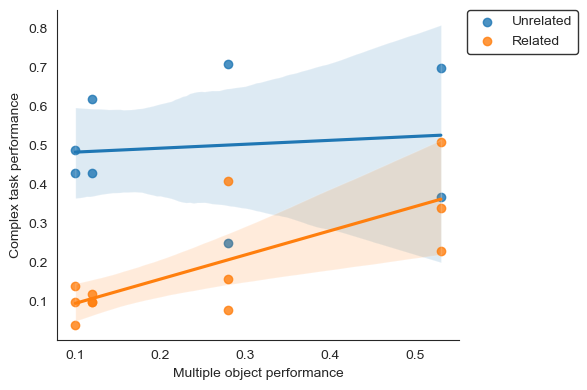

In [29]:
sns.lmplot(data=temp_df, x='Multiple_object_performance', y="annotation",hue='Relatedness',height=4,aspect=1.5,n_boot=10000,legend=False)
_ = plt.ylabel('Complex task performance')
_ = plt.xlabel('Multiple object performance')
_ = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,edgecolor='black')
plt.tight_layout()

#### Statistical analyses

When analysing the data seperately for unrelated and related tasks we find a significant effect in related tasks but not unrelated tasks. When combining both datasets and testing for an interaction effect of relatedness and multiple object performance we find that this is not significant. Instead we find a main effect of multiple object performance across groups of relatedness.

In [30]:
lm_df = temp_df.loc[temp_df['Relatedness']=='Related']
mod = smf.ols(formula='annotation ~ Multiple_object_performance', data=lm_df)
res = mod.fit()
res.summary()

/Users/jachterb/opt/anaconda3/envs/Benchmark_analysis/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             annotation   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     13.10
Date:                Wed, 22 Mar 2023   Prob (F-statistic):            0.00469
Time:                        15:13:58   Log-Likelihood:                 11.422
No. Observations:                  12   AIC:                            -18.84
Df Residuals:                      10   BIC:                            -17.88
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.0342      0.053      0.643      0.535      -0.084       0.153
Multiple_object_performance     0.6213      0.172      3.620      0.005       0.239       1.004
==============================================================================
Omnibus:                        2.166   Durbin-Watson:                   2.733
Prob(Omnibus):                  0.339   Jarque-Bera (JB):                0.930
Skew:                           0.682   Prob(JB):                        0.628
Kurtosis:                       2.986   Cond. No.                         6.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
lm_df = temp_df.loc[temp_df['Relatedness']=='Unrelated']
mod = smf.ols(formula='annotation ~ Multiple_object_performance', data=lm_df)
res = mod.fit()
res.summary()

/Users/jachterb/opt/anaconda3/envs/Benchmark_analysis/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             annotation   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.152
Method:                 Least Squares   F-statistic:                   0.07802
Date:                Wed, 22 Mar 2023   Prob (F-statistic):              0.789
Time:                        15:13:58   Log-Likelihood:                 3.7074
No. Observations:                   8   AIC:                            -3.415
Df Residuals:                       6   BIC:                            -3.256
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.4740      0.112      4.238      0.005       0.200       0.748
Multiple_object_performance     0.1009      0.361      0.279      0.789      -0.783       0.984
==============================================================================
Omnibus:                        0.595   Durbin-Watson:                   3.213
Prob(Omnibus):                  0.743   Jarque-Bera (JB):                0.501
Skew:                          -0.135   Prob(JB):                        0.779
Kurtosis:                       1.805   Cond. No.                         6.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
mod = smf.ols(formula='annotation ~  C(Relatedness, Sum) * Multiple_object_performance', data=temp_df)
res = mod.fit()
res.summary()
sm.stats.anova_lm(res, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
"C(Relatedness, Sum)",1.0,0.448963,0.448963,24.763324,0.000137
Multiple_object_performance,1.0,0.101102,0.101102,5.576453,0.031220
"C(Relatedness, Sum):Multiple_object_performance",1.0,0.038507,0.038507,2.123910,0.164363
Residual,16.0,0.290083,0.018130,NaN,NaN


## Influences on task performance / difficulty effects

### Conditional generation: object order

Example prompt: A jar or a squirrel - only render containers

The position of the correct object says whether the prompts asks to generate the first or the second object.

In [33]:
temp_df = annotations_df.loc[annotations_df['Task']=='Conditional generation']
temp_df = temp_df.merge(prompt_dir[['ID','Object_num']],left_on='Prompt_no',right_on='ID')
plot_df = temp_df.groupby(['Algorithm','Object_num'])['annotation'].mean().reset_index()
plot_df['annotation']=plot_df['annotation']*100
plot_df['Object_num']=plot_df['Object_num'].astype('int')

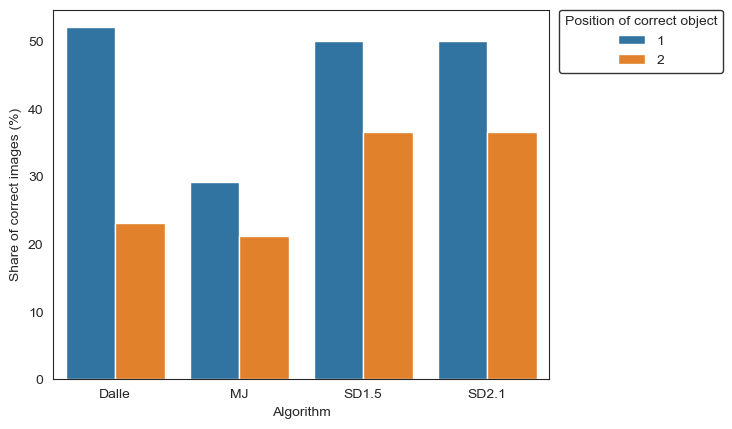

In [34]:
sns.barplot(data=plot_df, x='Algorithm',hue='Object_num',y='annotation')
_ = plt.ylabel('Share of correct images (%)')
_ = plt.xlabel('Algorithm')
_ = plt.legend(title='Position of correct object', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,edgecolor='black')

### Conditional generation: Extra characteristic

Example prompts:
- Without extra characteistic: A jar or a squirrel - only render containers
- With extra characteistic: A white mug or a black pen- only render white objects

Extra characteristic = True means that the algortihms needs to differentiate between the two object via an explicitply mentioned extra charateristic and not via an intrinsic property of the object.

In [35]:
temp_df = annotations_df.loc[annotations_df['Task']=='Conditional generation']
temp_df = temp_df.merge(prompt_dir[['ID','Extra_characteristic']],left_on='Prompt_no',right_on='ID')
plot_df = temp_df.groupby(['Algorithm','Extra_characteristic'])['annotation'].mean().reset_index()
plot_df['annotation']=plot_df['annotation']*100

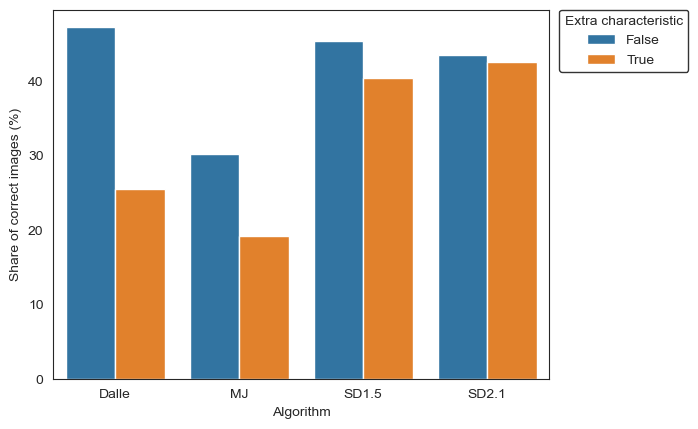

In [36]:
sns.barplot(data=plot_df, x='Algorithm',hue='Extra_characteristic',y='annotation')
_ = plt.ylabel('Share of correct images (%)')
_ = plt.xlabel('Algorithm')
_ = plt.legend(title='Extra characteristic', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,edgecolor='black')

### Multi object: Number of objects

How many distinct objects are named in the prompt.

In [37]:
temp_df = annotations_df.loc[annotations_df['Task']=='Multiple objects']
temp_df = temp_df.merge(prompt_dir[['ID','Num_objects']],left_on='Prompt_no',right_on='ID')
plot_df = temp_df.groupby(['Algorithm','Num_objects'])['annotation'].mean().reset_index()
plot_df['annotation']=plot_df['annotation']*100
plot_df['Num_objects']=plot_df['Num_objects'].astype('int')

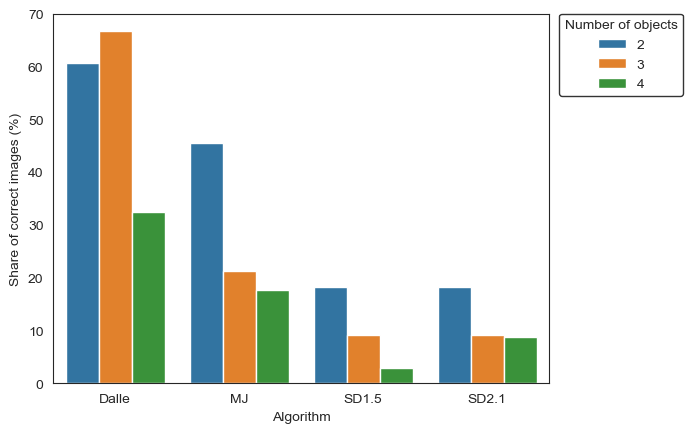

In [38]:
sns.barplot(data=plot_df, x='Algorithm',hue='Num_objects',y='annotation')
_ = plt.ylabel('Share of correct images (%)')
_ = plt.xlabel('Algorithm')
_ = plt.legend(title='Number of objects', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,edgecolor='black')

### Multi object: Common combination of objects

Are the object in the prompt commonly seen together in images, like: “bike, helmet, lock”
Or not commonly seen together: “Yarn, robin, mouthwash”

In [39]:
temp_df = annotations_df.loc[annotations_df['Task']=='Multiple objects']
temp_df = temp_df.merge(prompt_dir[['ID','Common']],left_on='Prompt_no',right_on='ID')
plot_df = temp_df.groupby(['Algorithm','Common'])['annotation'].mean().reset_index()
plot_df['annotation']=plot_df['annotation']*100

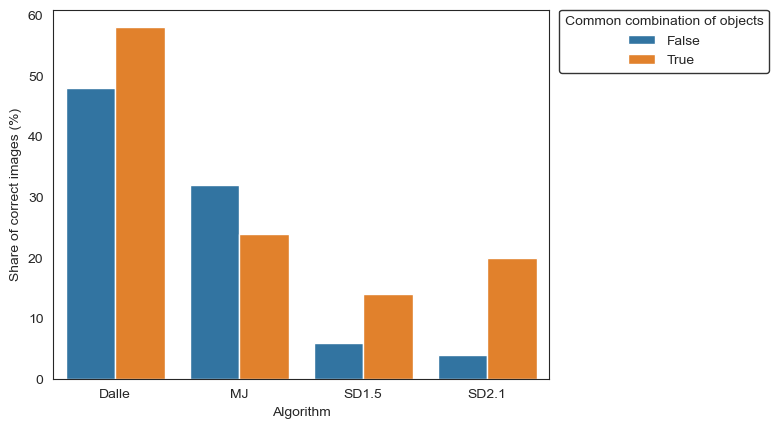

In [40]:
sns.barplot(data=plot_df, x='Algorithm',hue='Common',y='annotation')
_ = plt.ylabel('Share of correct images (%)')
_ = plt.xlabel('Algorithm')
_ = plt.legend(title='Common combination of objects', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,edgecolor='black')

### Multi object: Combined common object and count

In [41]:
temp_df = annotations_df.loc[annotations_df['Task']=='Multiple objects']
temp_df = temp_df.merge(prompt_dir[['ID','Common','Num_objects']],left_on='Prompt_no',right_on='ID')
plot_df = temp_df.groupby(['Num_objects','Common'])['annotation'].mean().reset_index()
plot_df['annotation']=plot_df['annotation']*100
plot_df['Num_objects']=plot_df['Num_objects'].astype('int')
plot_df['Common'] = plot_df['Common'].map({True:'Common combination',False:'Uncommon combination'})

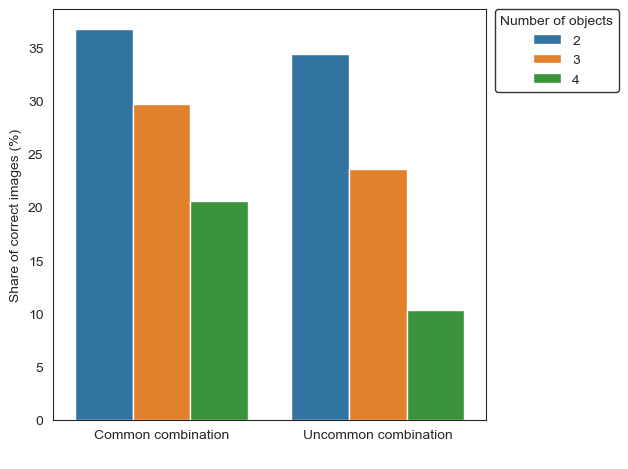

In [42]:
sns.barplot(data=plot_df, x='Common',hue='Num_objects',y='annotation',order=['Common combination','Uncommon combination'])
_ = plt.ylabel('Share of correct images (%)')
_ = plt.xlabel(' ')
_ = plt.legend(title='Number of objects', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,edgecolor='black')
plt.tight_layout()

### Counting: Object count

The number of objects in counting prompt.

In [43]:
order = list(range(2,13))
order = [str(i) for i in order]

In [44]:
temp_df = annotations_df.loc[annotations_df['Task']=='Counting']
plot_df = temp_df.groupby(['Algorithm','Task_specific_label'])['annotation'].mean().reset_index()
plot_df['annotation']=plot_df['annotation']*100

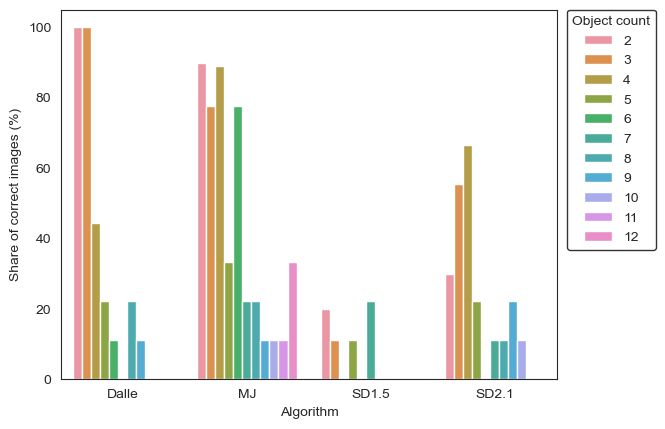

In [45]:
sns.barplot(data=plot_df, x='Algorithm',hue='Task_specific_label',y='annotation',hue_order=order)
_ = plt.ylabel('Share of correct images (%)')
_ = plt.xlabel('Algorithm')
_ = plt.legend(title='Object count', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,edgecolor='black')

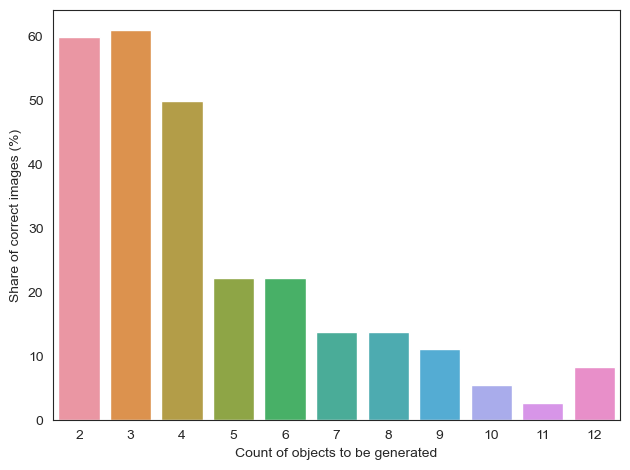

In [46]:
temp_df = annotations_df.loc[annotations_df['Task']=='Counting']
plot_df = temp_df.groupby(['Task_specific_label'])['annotation'].mean().reset_index()
plot_df['annotation']=plot_df['annotation']*100
sns.barplot(data=plot_df,x='Task_specific_label',y='annotation',order=order)
_ = plt.ylabel('Share of correct images (%)')
_ = plt.xlabel('Count of objects to be generated')
plt.tight_layout()

### Controlled counting: Object count

The same as above but in the controlled counting task to control for object identities.

In [47]:
temp_df = annotations_df.loc[annotations_df['Task']=='Controlled single object counting']
plot_df = temp_df.groupby(['Algorithm','Task_specific_label'])['annotation'].mean().reset_index()
plot_df['annotation']=plot_df['annotation']*100

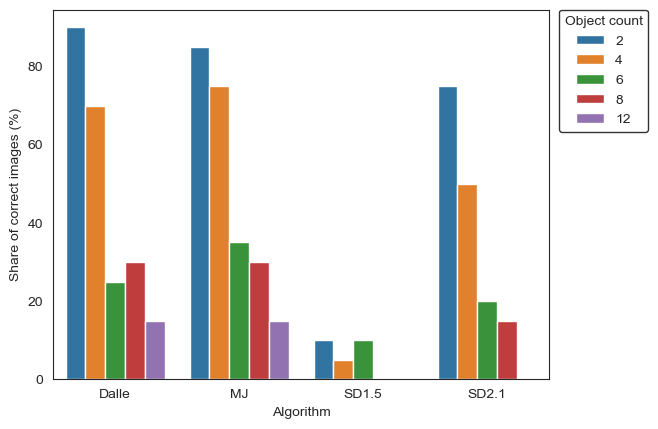

In [48]:
sns.barplot(data=plot_df, x='Algorithm',hue='Task_specific_label',y='annotation',hue_order=['2','4','6','8','12'])
_ = plt.ylabel('Share of correct images (%)')
_ = plt.xlabel('Algorithm')
_ = plt.legend(title='Object count', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,edgecolor='black')

### Chimeras: Number of combined features

- Example for features = 2: "a horse with the fur of a tiger"
- Example for features = 3: "a zebra with the mane of a lion and the wings of a bat"

In [49]:
temp_df = annotations_df.loc[annotations_df['Task']=='Chimeras']
temp_df = temp_df.merge(prompt_dir[['ID','Num_features']],left_on='Prompt_no',right_on='ID')
plot_df = temp_df.groupby(['Algorithm','Num_features'])['annotation'].mean().reset_index()
plot_df['annotation']=plot_df['annotation']*100
plot_df['Num_features']=plot_df['Num_features'].astype('int')

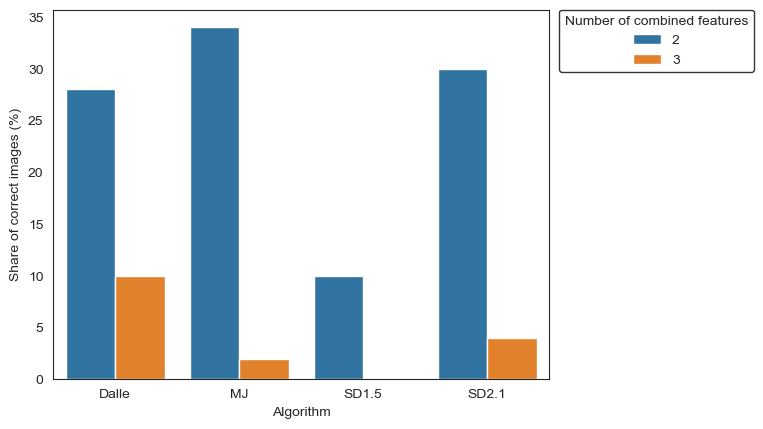

In [50]:
sns.barplot(data=plot_df, x='Algorithm',hue='Num_features',y='annotation')
_ = plt.ylabel('Share of correct images (%)')
_ = plt.xlabel('Algorithm')
_ = plt.legend(title='Number of combined features', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,edgecolor='black')